# CNN Training

Target of this code is to train a CNN network to classify images of a digital readout to the digits 0 to 9. Additionally a category "NaN" is introduced, to mark images that are not amibiguous.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Running: ################################
    
Version = "7.2.1-Small-v3"                      # Used for tflite Filename
Training_Percentage = 0.2              # 0.0 = Use all Images for Training
Epoch_Anz = 200

##########################################################################


import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import History 
from tensorflow.keras.utils import to_categorical
from PIL import Image 

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Inside subdirectories are expected from -1, 0, 1, ... 9 in which the pictures are sorted according to their values (=category)
* Picture size must be 20x32 with 3 color channels (RGB)
* The filename can be arbitrary

* The images are stored in the x_data[]
* The expected category for each image in the corresponding y_data[]

* The last step is a shuffle (from sklearn.utils) and split the data into training and validation data

In [2]:
Input_dir='ziffer_sortiert_resize'

files = glob.glob(Input_dir + '/*.*')
x_data = []
y_data = []

subdir = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "NaN"]

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '/*.jpg')
    if aktsubdir == "NaN":
        category = 10                # NaN does not work --> convert to 10
    else:
        category = aktsubdir
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        x_data.append(test_image)
        y_data.append(np.array([category]))

x_data = np.array(x_data)
y_data = np.array(y_data)
y_data = to_categorical(y_data, 11)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(817, 32, 20, 3)
(817, 11)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 20, 3)
* Number of output layers: 11
* As loss function "categorical_crossentropy" is choosen, as it is a categories task

In [3]:
model = Sequential()
model.add(BatchNormalization(input_shape=(32,20,3)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(11, activation = "softmax"))
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 20, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 20, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 10, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 10, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 5, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 5, 32)          9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 2, 32)          0

# Training
The input pictures are randomly scattered for brightness, pixel shift variations and rotation angle. This is implemented with a ImageDataGenerator.


In [4]:
Batch_Size = 4
Shift_Range = 1
Brightness_Range = 0.3
Rotation_Angle = 10
ZoomRange = 0.4

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], 
                             height_shift_range=[-Shift_Range,Shift_Range],
                             brightness_range=[1-Brightness_Range,1+Brightness_Range],
                             zoom_range=[1-ZoomRange, 1+ZoomRange],
                             rotation_range=Rotation_Angle)

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, epochs = Epoch_Anz)



c:\users\diego\anaconda3\envs\py36\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
205/205 [==============================] - 2s 7ms/step - loss: 2.0921 - accuracy: 0.4144 - val_loss: 1.7680 - val_accuracy: 0.4939
Epoch 2/200
205/205 [==============================] - 1s 5ms/step - loss: 1.5778 - accuracy: 0.4852 - val_loss: 1.1203 - val_accuracy: 0.6341
Epoch 3/200
205/205 [==============================] - 1s 5ms/step - loss: 1.1678 - accuracy: 0.6226 - val_loss: 0.7120 - val_accuracy: 0.7805
Epoch 4/200
205/205 [==============================] - 1s 5ms/step - loss: 0.8073 - accuracy: 0.7556 - val_loss: 0.7222 - val_accuracy: 0.7988
Epoch 5/200
205/205 [==============================] - 1s 6ms/step - loss: 0.9149 - accuracy: 0.7059 - val_loss: 0.6552 - val_accuracy: 0.8171
Epoch 6/200
205/205 [==============================] - 1s 5ms/step - loss: 0.6901 - accuracy: 0.7837 - val_loss: 0.5572 - val_accuracy: 0.8293
Epoch 7/200
205/205 [==============================] - 1s 5ms/step - loss: 0.5726 - accuracy: 0.8202 - val_loss: 0.4728 - val_accuracy: 0.8476

Epoch 58/200
205/205 [==============================] - 1s 5ms/step - loss: 0.1079 - accuracy: 0.9637 - val_loss: 0.0537 - val_accuracy: 0.9817
Epoch 59/200
205/205 [==============================] - 1s 5ms/step - loss: 0.0908 - accuracy: 0.9696 - val_loss: 0.1499 - val_accuracy: 0.9634
Epoch 60/200
205/205 [==============================] - 1s 5ms/step - loss: 0.0980 - accuracy: 0.9681 - val_loss: 0.1394 - val_accuracy: 0.9573
Epoch 61/200
205/205 [==============================] - 1s 5ms/step - loss: 0.1019 - accuracy: 0.9680 - val_loss: 0.0496 - val_accuracy: 0.9878
Epoch 62/200
205/205 [==============================] - 1s 5ms/step - loss: 0.1032 - accuracy: 0.9651 - val_loss: 0.0795 - val_accuracy: 0.9756
Epoch 63/200
205/205 [==============================] - 1s 5ms/step - loss: 0.1036 - accuracy: 0.9673 - val_loss: 0.0678 - val_accuracy: 0.9817
Epoch 64/200
205/205 [==============================] - 1s 5ms/step - loss: 0.1365 - accuracy: 0.9605 - val_loss: 0.1275 - val_accuracy:

Epoch 115/200
205/205 [==============================] - 1s 5ms/step - loss: 0.1097 - accuracy: 0.9717 - val_loss: 0.0501 - val_accuracy: 0.9817
Epoch 116/200
205/205 [==============================] - 1s 5ms/step - loss: 0.0747 - accuracy: 0.9795 - val_loss: 0.0526 - val_accuracy: 0.9756
Epoch 117/200
205/205 [==============================] - 1s 6ms/step - loss: 0.0761 - accuracy: 0.9853 - val_loss: 0.0825 - val_accuracy: 0.9817
Epoch 118/200
205/205 [==============================] - 1s 5ms/step - loss: 0.0916 - accuracy: 0.9716 - val_loss: 0.0299 - val_accuracy: 0.9878
Epoch 119/200
205/205 [==============================] - 1s 6ms/step - loss: 0.0955 - accuracy: 0.9786 - val_loss: 0.0578 - val_accuracy: 0.9756
Epoch 120/200
205/205 [==============================] - 1s 6ms/step - loss: 0.0423 - accuracy: 0.9875 - val_loss: 0.0301 - val_accuracy: 0.9878
Epoch 121/200
205/205 [==============================] - 1s 5ms/step - loss: 0.0515 - accuracy: 0.9849 - val_loss: 0.0446 - val_ac

205/205 [==============================] - 1s 6ms/step - loss: 0.0391 - accuracy: 0.9877 - val_loss: 0.0233 - val_accuracy: 0.9878
Epoch 172/200
205/205 [==============================] - 1s 6ms/step - loss: 0.0462 - accuracy: 0.9853 - val_loss: 0.0531 - val_accuracy: 0.9878
Epoch 173/200
205/205 [==============================] - 1s 7ms/step - loss: 0.1140 - accuracy: 0.9798 - val_loss: 0.0376 - val_accuracy: 0.9756
Epoch 174/200
205/205 [==============================] - 1s 6ms/step - loss: 0.0421 - accuracy: 0.9882 - val_loss: 0.0244 - val_accuracy: 0.9939
Epoch 175/200
205/205 [==============================] - 1s 6ms/step - loss: 0.0542 - accuracy: 0.9896 - val_loss: 0.0880 - val_accuracy: 0.9878
Epoch 176/200
205/205 [==============================] - 1s 6ms/step - loss: 0.0842 - accuracy: 0.9729 - val_loss: 0.0626 - val_accuracy: 0.9817
Epoch 177/200
205/205 [==============================] - 1s 6ms/step - loss: 0.0510 - accuracy: 0.9853 - val_loss: 0.0729 - val_accuracy: 0.9695

0.9634146341463414


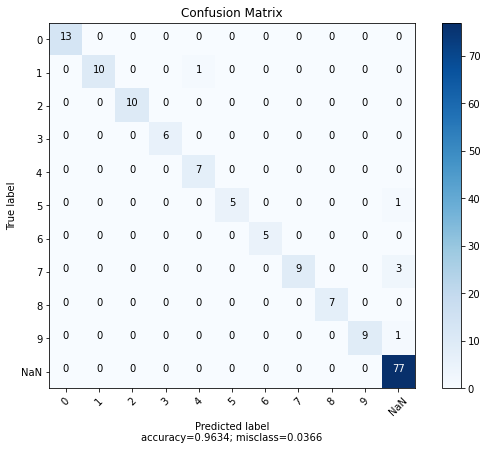

In [16]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

if (Training_Percentage > 0):
    class_names = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "NaN"]
    y_pred = model.predict(x=X_test)
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import accuracy_score
    print(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))
    cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
    plot_confusion_matrix(cm           = cm, 
                      normalize    = False,
                      target_names = class_names,
                      title        = "Confusion Matrix")
    

### Learing result
 
* Visualization of the training and validation results

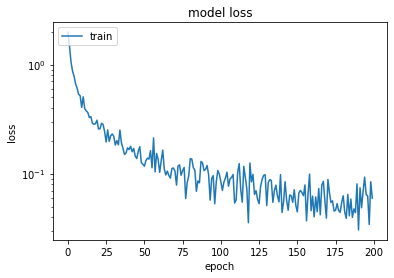

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])
plt.semilogy(history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* x-axis walks through each pixel, y-axis shows the result

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


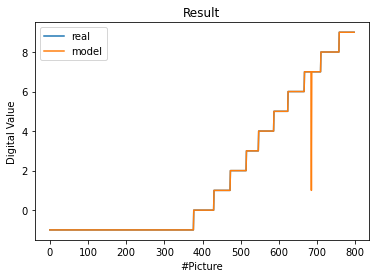

In [6]:
Input_dir='ziffer_sortiert_resize'
subdir = ["NaN", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
res = []

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '\*.jpg')
    if aktsubdir == "NaN":
        zw1 = -1
    else:
        zw1 = int(aktsubdir)
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        img = np.reshape(test_image,[1,32,20,3])
        classes = model.predict_classes(img)
        classes = classes[0]
        if classes == 10: 
            classes = -1
        zw2 = classes
        zw3 = zw2 - zw1
        res.append(np.array([zw1, zw2, zw3]))

res = np.asarray(res)


plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Digital Value')
plt.xlabel('#Picture')
plt.legend(['real','model'], loc='upper left')
plt.show()

### Save the model

* Save the model to the file with the "h5" file format

In [7]:
FileName = "Train_CNN_Digital-Readout_Version_" + Version
# model.save(FileName + ".h5")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

218936

In [8]:
FileName = "Train_CNN_Digital-Readout_Version_" + Version
# model.save(FileName + ".h5")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

218936

### Check each image for expected and deviation
* setting the switch "only_deviation = true" will only print the images for which the classification and the CNN-result deviates

The output contains the following information:

| Filename      | Expected Category           | Predicted Category        |
|------------- |:-----------------------------:|--------------|
| ziffer_sortiert_resize_NaN/5\Ziffer_4_0034.jpg | 4  | -1 |


In [9]:
Input_dir='ziffer_sortiert_resize'
only_deviation = True

subdir = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "NaN"]

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '\*.jpg')
    expected_class = aktsubdir
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        img = np.reshape(test_image,[1,32,20,3])
        classes = model.predict_classes(img)
        classes = classes[0]
        if classes == 10: 
            classes = "NaN"
        if only_deviation == True:
            if str(classes) != str(expected_class):
                print(aktfile + " " + aktsubdir +  " " + str(classes))
        else:
            print(aktfile + " " + aktsubdir +  " " + str(classes))


ziffer_sortiert_resize/7\D6_2020-08-19_21-15-56.jpg 7 1


Checking the images shows, that this are border line images, which can be interpreted as a good digit or a faulty one.